# Small but Smart (Unified): **YOLOv11 Knowledge Distillation**
Roboflow → Teacher → Pseudo‑Labels → Merge → Student → **(Optional) KD Loss Fine‑Tune**

Bu tek defter iki KD yaklaşımını birleştirir:
- **Pseudo‑Label Distillation** (kolay/sağlam)
- **Feature/Response‑Level KD** (ileri, callback ile ek loss)


## 1) Runtime & Kurulum

In [1]:
!nvidia-smi || true
!pip -q install ultralytics>=8.3.0 roboflow>=1.1.29 opencv-python tqdm pyyaml albumentations --upgrade
from ultralytics import YOLO
import os, sys, json, glob, shutil, random, math, yaml, time
from pathlib import Path
import numpy as np, cv2, torch
from tqdm import tqdm
print('ultralytics', __import__('ultralytics').__version__)
print('torch', torch.__version__)


Wed Oct  1 09:24:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             57W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 2) Yapılandırma

In [2]:
# === Roboflow ===
RF_API_KEY = 'bVCHIdUmWTMSr6ETOu3O'  #@param {type:'string'}
WORKSPACE  = 'computer-vision-yqyos'  #@param {type:'string'}
PROJECT    = 'merged-cracks'          #@param {type:'string'}
VERSION    = 2                        #@param {type:'number'}

# === Modeller ===
TEACHER_MODEL = 'yolov11x.pt'  #@param ['yolov11x.pt','yolov11l.pt','yolov11m.pt']
STUDENT_MODEL = 'yolov11n.pt'  #@param ['yolov11n.pt','yolov11s.pt','yolov11m.pt']

# === Eğitim parametreleri ===
teacher_epochs = 50     #@param {type:'integer'}
student_epochs = 100    #@param {type:'integer'}
imgsz = 640             #@param {type:'integer'}
batch = -1              #@param {type:'integer'}
patience = 25           #@param {type:'integer'}

# === Pseudo‑label ayarları ===
pl_conf_threshold = 0.35   #@param {type:'number'}
pl_iou_nms = 0.6           #@param {type:'number'}
use_val_for_pseudo = False #@param {type:'boolean'}

# === İleri KD (feature/response) ayarları ===
enable_feature_kd = True      #@param {type:'boolean'}
kd_logit_weight   = 1.0       #@param {type:'number'}
kd_feature_weight = 0.2       #@param {type:'number'}
feature_layers = ['model.6.cv3.act', 'model.8.cv3.act', 'model.10.cv3.act']

# === Dizinler ===
BASE_DIR   = Path.cwd() / 'yolo11_kd_allinone'
DATASETS   = BASE_DIR / 'datasets'
TEACHER_DIR= BASE_DIR / 'teacher'
STUDENT_DIR= BASE_DIR / 'student'
PSEUDO_DIR = BASE_DIR / 'pseudo'
for p in [BASE_DIR, DATASETS, TEACHER_DIR, STUDENT_DIR, PSEUDO_DIR]:
    p.mkdir(parents=True, exist_ok=True)
print('Workdir:', BASE_DIR)


Workdir: /content/yolo11_kd_allinone


## 3) Roboflow’dan verisetini indir

In [3]:
from roboflow import Roboflow
assert RF_API_KEY, '⚠️ RF_API_KEY giriniz.'
rf = Roboflow(api_key=RF_API_KEY)
project = rf.workspace(WORKSPACE).project(PROJECT)
dataset = project.version(VERSION).download('yolov11')
DATASET_DIR = Path(dataset.location)
print('✅ Dataset:', DATASET_DIR)


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to merged-cracks-2 in yolov11:: 100%|██████████| 22098/22098 [00:02<00:00, 7795.35it/s] 


✅ Dataset: /content/merged-cracks-2


## 4) Hızlı kontrol: birkaç resim göster

Train images: 10409


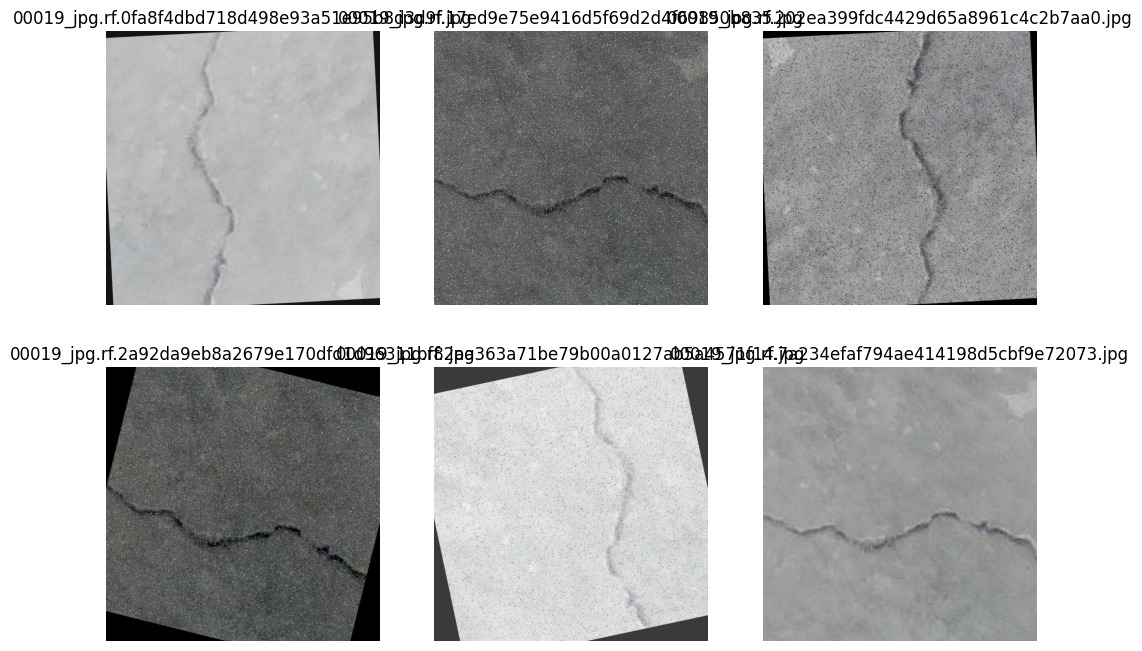

In [4]:
import matplotlib.pyplot as plt
def show_images(img_paths, cols=3, max_show=6):
    paths = img_paths[:max_show]
    rows = math.ceil(len(paths)/cols)
    plt.figure(figsize=(cols*4, rows*4))
    for i,p in enumerate(paths):
        img = cv2.imread(str(p))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img); plt.axis('off'); plt.title(Path(p).name)
    plt.show()

train_images = sorted(list((DATASET_DIR / 'train' / 'images').glob('*.*')))
print('Train images:', len(train_images))
show_images(train_images, cols=3, max_show=6)


## 5) Teacher’ı eğit ve değerlendir

In [7]:
import ultralytics
print(ultralytics.__version__)


8.3.204


In [9]:
# --- Safe loader for YOLO11-x weights + training & eval (no manual URL) ---
!pip -q install -U ultralytics>=8.3.0

from ultralytics import YOLO
import torch, pathlib

data_yaml = DATASET_DIR / 'data.yaml'
assert data_yaml.exists(), f'data.yaml yok: {data_yaml}'

MODEL_NAME = "yolo11x.pt"   # DÜZELTME: 'yolov11x.pt' DEĞİL, 'yolo11x.pt'!
device = 0 if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# Ultralytics otomatik indirir (dosya yoksa hub'dan çeker)
try:
    teacher = YOLO(MODEL_NAME)
except Exception as e:
    print("İlk deneme başarısız:", e)
    # Daha küçük bir fallback dene (RAM/GPU için faydalı olabilir)
    MODEL_NAME = "yolo11l.pt"
    teacher = YOLO(MODEL_NAME)

# --- Train Teacher ---
teacher_results = teacher.train(
    data=str(data_yaml),
    epochs=teacher_epochs,
    imgsz=imgsz,
    batch=batch,
    patience=patience,
    project=str(TEACHER_DIR),
    name='train',
    pretrained=True,
    device=device
)

# --- Evaluate Teacher on test split ---
teacher_metrics = teacher.val(
    data=str(data_yaml),
    split='test',
    imgsz=imgsz,
    project=str(TEACHER_DIR),
    name='val_test',
    device=device
)
print('Teacher test metrics:', teacher_metrics)


Device: 0
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/merged-cracks-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=25, perspectiv

## 6) Teacher ile Pseudo‑Label üret

In [10]:
def predict_and_write_labels(model, img_dir: Path, out_lbl_dir: Path, conf=0.35, iou=0.6, imgsz=640):
    out_lbl_dir.mkdir(parents=True, exist_ok=True)
    res = model.predict(source=str(img_dir), conf=conf, iou=iou, imgsz=imgsz,
                        stream=True, device=0 if torch.cuda.is_available() else 'cpu', verbose=False)
    for r in res:
        img_path = Path(r.path)
        boxes = r.boxes
        if boxes is None or len(boxes) == 0:
            (out_lbl_dir / (img_path.stem + '.txt')).write_text('')
            continue
        cls = boxes.cls.cpu().numpy().astype(int)
        confs = boxes.conf.cpu().numpy()
        xyxy = boxes.xyxy.cpu().numpy()
        h, w = r.orig_shape
        lines = []
        for (x1,y1,x2,y2), c, cf in zip(xyxy, cls, confs):
            cx = ((x1 + x2) / 2) / w; cy = ((y1 + y2) / 2) / h
            bw = (x2 - x1) / w; bh = (y2 - y1) / h
            lines.append(f"{c} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f} {cf:.6f}")
        (out_lbl_dir / (img_path.stem + '.txt')).write_text('\n'.join(lines))

splits = ['train'] + (['val'] if use_val_for_pseudo else [])
for split in splits:
    img_dir = DATASET_DIR / split / 'images'
    out_lbl = PSEUDO_DIR / split / 'labels'
    print(f"Generating Pseudo Labels for '{split}'...")
    predict_and_write_labels(teacher, img_dir, out_lbl, conf=pl_conf_threshold, iou=pl_iou_nms, imgsz=imgsz)
print('✅ Pseudo‑labels:', PSEUDO_DIR)


Generating Pseudo Labels for 'train'...
✅ Pseudo‑labels: /content/yolo11_kd_allinone/pseudo


## 7) GT + Pseudo birleştir

In [13]:
def load_yolo_labels(lbl_path: Path, with_conf: bool):
    if not lbl_path.exists() or lbl_path.stat().st_size == 0:
        return []
    lines = [l.strip() for l in lbl_path.read_text().splitlines() if l.strip()]
    out = []
    for l in lines:
        parts = l.split()
        if with_conf and len(parts) == 6:
            c,x,y,w,h,conf = parts
            out.append((int(c), float(x), float(y), float(w), float(h), float(conf)))
        else:
            c,x,y,w,h = parts[:5]
            out.append((int(c), float(x), float(y), float(w), float(h)))
    return out

def iou_xywh(a, b):
    ax1, ay1 = a[0]-a[2]/2, a[1]-a[3]/2; ax2, ay2 = a[0]+a[2]/2, a[1]+a[3]/2
    bx1, by1 = b[0]-b[2]/2, b[1]-b[3]/2; bx2, by2 = b[0]+b[2]/2, b[1]+b[3]/2
    inter_x1, inter_y1 = max(ax1,bx1), max(ay1,by1)
    inter_x2, inter_y2 = min(ax2,bx2), min(ay2,by2)
    inter_w, inter_h = max(0, inter_x2-inter_x1), max(0, inter_y2-inter_y1)
    inter = inter_w * inter_h
    union = a[2]*a[3] + b[2]*b[3] - inter + 1e-9
    return inter/union

def merge_split(split):
    gt_lbl_dir = DATASET_DIR / split / 'labels'
    ps_lbl_dir = PSEUDO_DIR / split / 'labels'
    merged_lbl_dir = STUDENT_DIR / 'merged' / split / 'labels'
    merged_img_dir = STUDENT_DIR / 'merged' / split / 'images'
    merged_lbl_dir.mkdir(parents=True, exist_ok=True)
    merged_img_dir.mkdir(parents=True, exist_ok=True)

    img_dir = DATASET_DIR / split / 'images'
    for img_path in tqdm(sorted(img_dir.glob('*.*')), desc=f'Merge {split}'):
        shutil.copy2(img_path, merged_img_dir / img_path.name)
        gt = load_yolo_labels(gt_lbl_dir / (img_path.stem + '.txt'), with_conf=False)
        ps = load_yolo_labels(ps_lbl_dir / (img_path.stem + '.txt'), with_conf=True)
        merged = [(c,x,y,w,h) for (c,x,y,w,h) in gt]
        for (c,x,y,w,h,conf) in ps:
            if conf < pl_conf_threshold:
                continue
            ok = True
            for g in gt:
                if iou_xywh((x,y,w,h), (g[1],g[2],g[3],g[4])) >= 0.5:
                    ok = False; break
            if ok:
                merged.append((c,x,y,w,h))
        out_path = merged_lbl_dir / (img_path.stem + '.txt')
        if merged:
            out_lines = [f'{c} {x:.6f} {y:.6f} {w:.6f} {h:.6f}' for (c,x,y,w,h) in merged]
            out_path.write_text('\n'.join(out_lines))
        else:
            out_path.write_text('')

merge_split('train')
if use_val_for_pseudo:
    merge_split('val')

merged_root = STUDENT_DIR / 'merged'
merged_yaml = STUDENT_DIR / 'data_merged.yaml'
orig_yaml = yaml.safe_load((DATASET_DIR / 'data.yaml').read_text())
new_yaml = dict(orig_yaml)
new_yaml['train'] = str(merged_root / 'train' / 'images')
new_yaml['val']   = str(merged_root / 'val' / 'images') if (merged_root / 'val' / 'images').exists() else str(DATASET_DIR / 'val' / 'images')
new_yaml['test']  = str(DATASET_DIR / 'test' / 'images')
merged_yaml.write_text(yaml.safe_dump(new_yaml, sort_keys=False))
print('✅ Merged YAML:', merged_yaml)


Merge train: 100%|██████████| 10409/10409 [00:04<00:00, 2331.59it/s]

✅ Merged YAML: /content/yolo11_kd_allinone/student/data_merged.yaml


## 8) Student’i (GT+Pseudo) eğit ve değerlendir

In [18]:
# --- FIX: Roboflow 'valid' vs 'val' farkını otomatik düzelt ve data_merged.yaml'ı yeniden yaz ---
from pathlib import Path
import yaml, os

merged_root = STUDENT_DIR / "merged"
merged_yaml = STUDENT_DIR / "data_merged.yaml"
orig_yaml_path = DATASET_DIR / "data.yaml"
assert orig_yaml_path.exists(), f"Orijinal data.yaml yok: {orig_yaml_path}"

orig = yaml.safe_load(orig_yaml_path.read_text())

def find_split_path(base: Path, names=("train","val","valid","validation","test")):
    paths = {}
    for n in names:
        p = base / n / "images"
        if p.exists():
            paths[n] = p
    return paths

# Orijinal klasörleri tara
orig_paths = find_split_path(DATASET_DIR, names=("train","val","valid","validation","test"))
print("Orijinal bulunan klasörler:", {k: str(v) for k,v in orig_paths.items()})

# Merged (pseudo+GT) klasörleri tara
merged_paths = find_split_path(merged_root, names=("train","val"))
print("Merged bulunan klasörler:", {k: str(v) for k,v in merged_paths.items()})

# TRAIN yolu: merged/train varsa onu kullan; yoksa orijinal train
train_img_dir = merged_paths.get("train", orig_paths.get("train"))
assert train_img_dir and train_img_dir.exists(), "Train images klasörü bulunamadı!"
# VAL yolu: merged/val varsa onu kullan; yoksa orijinalde 'val'/'valid'/'validation' hangisi varsa onu kullan
val_img_dir = merged_paths.get("val", orig_paths.get("val") or orig_paths.get("valid") or orig_paths.get("validation"))
assert val_img_dir and val_img_dir.exists(), "Val/Valid images klasörü bulunamadı!"
# TEST yolu: varsa 'test'; yoksa val'i test olarak kullan (Ultralytics için opsiyonel ama çoğu akış bunu bekler)
test_img_dir = orig_paths.get("test", val_img_dir)

new_yaml = dict(orig)  # sınıf isimleri vs. korunur
new_yaml["train"] = str(train_img_dir)
new_yaml["val"]   = str(val_img_dir)    # Ultralytics 'val' anahtarını bekler
new_yaml["test"]  = str(test_img_dir)

merged_yaml.write_text(yaml.safe_dump(new_yaml, sort_keys=False, allow_unicode=True))
print("✅ data_merged.yaml güncellendi:")
print("  train:", new_yaml["train"])
print("  val  :", new_yaml["val"])
print("  test :", new_yaml["test"])

# Güvenlik kontrolü: klasörler dolu mu?
def count_imgs(p: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp")
    return sum(1 for x in p.glob("*") if x.suffix.lower() in exts)
print("  #train imgs:", count_imgs(Path(new_yaml["train"])))
print("  #val imgs  :", count_imgs(Path(new_yaml["val"])))
print("  #test imgs :", count_imgs(Path(new_yaml["test"])))


Orijinal bulunan klasörler: {'train': '/content/merged-cracks-2/train/images', 'valid': '/content/merged-cracks-2/valid/images', 'test': '/content/merged-cracks-2/test/images'}
Merged bulunan klasörler: {'train': '/content/yolo11_kd_allinone/student/merged/train/images'}
✅ data_merged.yaml güncellendi:
  train: /content/yolo11_kd_allinone/student/merged/train/images
  val  : /content/merged-cracks-2/valid/images
  test : /content/merged-cracks-2/test/images
  #train imgs: 10409
  #val imgs  : 416
  #test imgs : 218


In [19]:
from ultralytics import YOLO
import torch

student = YOLO("yolo11n.pt")   # doğru isim (v yok)
device = 0 if torch.cuda.is_available() else 'cpu'
student_results = student.train(
    data=str(STUDENT_DIR / "data_merged.yaml"),
    epochs=student_epochs,
    imgsz=imgsz,
    batch=batch,
    patience=patience,
    project=str(STUDENT_DIR),
    name='train_merged2',
    pretrained=True,
    device=device
)


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo11_kd_allinone/student/data_merged.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_merged22, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

## 9) (Opsiyonel) İleri KD: Feature/Response‑Level Fine‑Tune

In [44]:
# === Auto-select feature layers (no hardcoded names) ===
import torch, torch.nn as nn, cv2
from pathlib import Path

device = 0 if torch.cuda.is_available() else 'cpu'
student.model.to(device).train()
teacher.model.to(device).eval()

def _prep_img(path: Path, imgsz=640, device=device):
    img = cv2.imread(str(path))
    assert img is not None, f"Görüntü okunamadı: {path}"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (imgsz, imgsz))
    t = torch.from_numpy(img).float().permute(2,0,1).unsqueeze(0)/255.0
    return t.to(device)

def autoselect_feature_layers(model: nn.Module, sample_path: Path, imgsz=640, targets=(8,16,32)):
    """
    Forward sırasında TÜM modüllere hook atar, 4D tensor dönenleri toplar,
    sonra HxW boyutları hedef ölçeklere (img/8, img/16, img/32) en yakın olan
    3 katmanı seçer (P3, P4, P5 benzeri).
    """
    feats = {}
    hooks = []
    def mk_hook(name):
        def _hook(m, x, y):
            if torch.is_tensor(y) and y.dim() == 4:
                feats[name] = y.detach()
        return _hook

    # Tüm modülleri dinle
    for name, m in model.named_modules():
        try:
            hooks.append(m.register_forward_hook(mk_hook(name)))
        except Exception:
            pass

    # Tek bir örnekle dry-run
    with torch.no_grad():
        _ = model(_prep_img(sample_path, imgsz=imgsz))

    # Hedef uzaysal çözünürlükler
    target_sizes = [imgsz//t for t in targets]  # [img/8, img/16, img/32]
    candidates = []
    for name, t in feats.items():
        h,w = t.shape[-2:]
        candidates.append((name, h, w, t.shape[1]))

    def pick_closest(target):
        best = None; bestd = 1e9
        for name,h,w,c in candidates:
            d = abs(h-target)+abs(w-target)
            if d < bestd:
                best = name; bestd = d
        return best

    selected = []
    for ts in target_sizes:
        n = pick_closest(ts)
        if n and n not in selected:
            selected.append(n)

    # Temizlik
    for h in hooks:
        try: h.remove()
        except: pass

    return selected[:3]

# Veri kümesinden bir örnek al
train_img_dir = Path((STUDENT_DIR / "merged" / "train" / "images") if (STUDENT_DIR / "merged" / "train" / "images").exists()
                     else (DATASET_DIR / "train" / "images"))
sample_img = next(iter(sorted(train_img_dir.glob("*.*"))))
print("Örnek görüntü:", sample_img)

# Öğrenci modeline göre katmanları otomatik seç
feature_layers = autoselect_feature_layers(student.model, sample_img, imgsz=imgsz)
print("Seçilen feature katmanları:", feature_layers)

# --- Hook yardımcıları ve KD loss ---
def get_module_by_path(root: nn.Module, path: str):
    m = root
    for n in path.split('.'):
        m = getattr(m, n)
    return m

def make_hooks(model: nn.Module, layer_names):
    hooks = {}
    feats = {}
    def mk_hook(k):
        def _hook(m, x, y):
            feats[k] = y.detach()
        return _hook
    for n in layer_names:
        try:
            mod = get_module_by_path(model, n)
            hooks[n] = mod.register_forward_hook(mk_hook(n))
        except Exception as e:
            print(f"⚠️ Katman bulunamadı (atlandı): {n} ({e})")
    return hooks, feats

class KDCombinedLoss(nn.Module):
    def __init__(self, logit_weight=1.0, feature_weight=0.2, T=2.0):
        super().__init__()
        self.logit_weight = logit_weight
        self.feature_weight = feature_weight
        self.T = T
        self.kl = nn.KLDivLoss(reduction="batchmean")
        self.mse = nn.MSELoss()
    def logit_kd(self, s_logits, t_logits):
        s = s_logits / self.T; t = t_logits / self.T
        s2 = s.reshape(s.shape[0], -1); t2 = t.reshape(t.shape[0], -1)
        return (self.T**2) * self.kl(torch.log_softmax(s2, dim=1), torch.softmax(t2, dim=1))
    def feature_mse(self, s_list, t_list):
        if not s_list or not t_list:
            return torch.tensor(0.0, device=device)
        loss = 0.0; n = 0
        for s, t in zip(s_list, t_list):
            if s is None or t is None:
                continue
            if s.shape != t.shape:
                t = torch.nn.functional.interpolate(t, size=s.shape[-2:], mode="nearest")
                if t.shape[1] != s.shape[1]:
                    c = min(t.shape[1], s.shape[1])
                    loss += self.mse(s[:, :c], t[:, :c])
                else:
                    loss += self.mse(s, t)
            else:
                loss += self.mse(s, t)
            n += 1
        return loss / (n if n else 1)
    def forward(self, s_logits, t_logits, s_feats, t_feats):
        l_log = self.logit_kd(s_logits, t_logits) * kd_logit_weight
        l_fea = self.feature_mse(s_feats, t_feats) * kd_feature_weight
        return l_log + l_fea, {"kd_logit": l_log.detach(), "kd_feat": l_fea.detach()}

kd_loss_fn = KDCombinedLoss(kd_logit_weight, kd_feature_weight, T=2.0).to(device)

def _raw_logits(yolo_model, imgs):
    out = yolo_model.model(imgs)
    outs = []
    if isinstance(out, (list, tuple)):
        for t in out:
            if torch.is_tensor(t): outs.append(t)
            elif isinstance(t, (list, tuple)):
                for z in t:
                    if torch.is_tensor(z): outs.append(z)
    elif torch.is_tensor(out):
        outs = [out]
    else:
        raise RuntimeError("Raw head logits çıkarılamadı.")
    outs = [o if o.dim()==4 else o.unsqueeze(0) for o in outs]
    return torch.cat(outs, dim=1)

# Yeni hook seti (öğretmen & öğrenci)
tea_hooks, tea_feats = make_hooks(teacher.model, feature_layers)
stu_hooks, stu_feats = make_hooks(student.model, feature_layers)

# Callback fonksiyonu (trainer argümanlı)
def on_train_batch_end(trainer):
    imgs = trainer.batch["img"].to(device).float()
    with torch.no_grad():
        tea_logits = _raw_logits(teacher, imgs)
    stu_logits = _raw_logits(student, imgs)
    tea_list = [tea_feats.get(n) for n in feature_layers]
    stu_list = [stu_feats.get(n) for n in feature_layers]
    kd, parts = kd_loss_fn(stu_logits, tea_logits, stu_list, tea_list)
    trainer.loss += kd
    trainer.label_loss_items.update({
        "kd": float(kd.item()),
        "kd_logit": float(parts["kd_logit"].item()),
        "kd_feat": float(parts["kd_feat"].item())
    })


Örnek görüntü: /content/merged-cracks-2/train/images/00019_jpg.rf.0fa8f4dbd718d498e93a51e95b8d3d9f.jpg
Seçilen feature katmanları: ['model.3.conv', 'model.5.conv', 'model.0.act']


In [38]:
from pathlib import Path
import os, sys

# Senin kök klasörün (uygun şekilde değiştir)
STUDENT_ROOT = Path("/content/yolo11_kd_allinone/student")    # <-- BU kök dizin olsun (KOŞU klasörü değil)
DATA_YAML    = (STUDENT_ROOT / "data_merged.yaml").resolve()  # mutlaklaştır

if not DATA_YAML.exists():
    raise FileNotFoundError(f"data yaml bulunamadı: {DATA_YAML}")

print("DATA_YAML =", DATA_YAML)


DATA_YAML = /content/yolo11_kd_allinone/student/data_merged.yaml


In [41]:
# ==== GLOBAL (üst seviye) ====
tea_feats, stu_feats = {}, {}

def feature_hook_teacher(m, x, y):
    # m._feat_key attribute'u ile anahtar seç
    if torch.is_tensor(y):
        tea_feats[getattr(m, "_feat_key", "unknown")] = y.detach()

def feature_hook_student(m, x, y):
    if torch.is_tensor(y):
        stu_feats[getattr(m, "_feat_key", "unknown")] = y.detach()

_TEACHER_HOOKS = []
_STUDENT_HOOKS = []

def remove_feature_hooks():
    for h in _TEACHER_HOOKS:
        try: h.remove()
        except: pass
    for h in _STUDENT_HOOKS:
        try: h.remove()
        except: pass
    _TEACHER_HOOKS.clear(); _STUDENT_HOOKS.clear()

def attach_feature_hooks():
    remove_feature_hooks()
    for n in feature_layers:
        # Teacher
        try:
            tm = get_module_by_path(teacher.model, n)
            setattr(tm, "_feat_key", n)                    # <- closure yerine attribute
            _TEACHER_HOOKS.append(tm.register_forward_hook(feature_hook_teacher))
        except Exception as e:
            print(f"⚠️ Teacher katman atlandı: {n} ({e})")
        # Student
        try:
            sm = get_module_by_path(student.model, n)
            setattr(sm, "_feat_key", n)
            _STUDENT_HOOKS.append(sm.register_forward_hook(feature_hook_student))
        except Exception as e:
            print(f"⚠️ Student katman atlandı: {n} ({e})")


In [2]:
!pip install -U ultralytics>=8.3.0 -q
import torch
import torch.nn as nn
from ultralytics import YOLO
import torch.nn.functional as F

device = 0 if torch.cuda.is_available() else 'cpu'

# --- Teacher & Student ---
teacher = YOLO("yolo11x.pt")
student = YOLO("yolo11n.pt")
teacher.model.to(device).eval()
student.model.to(device).train()

# --- Basit KD Loss ---
class DetectionKDLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_output, teacher_output):
        """
        YOLO detection output'ları için KD loss
        Format: [batch, num_anchors, num_classes + 5]
        """
        if teacher_output is None:
            return torch.tensor(0.0, device=student_output.device)

        # Classification logits'lerini al (son 5 channel dışındakiler)
        s_cls = student_output[..., 5:]  # [batch, anchors, num_classes]
        t_cls = teacher_output[..., 5:]

        # Soft targets
        s_soft = F.log_softmax(s_cls / self.temperature, dim=-1)
        t_soft = F.softmax(t_cls / self.temperature, dim=-1)

        # KL divergence loss
        kl_loss = self.kl_loss(s_soft, t_soft) * (self.temperature ** 2)

        return kl_loss * self.alpha

kd_loss_fn = DetectionKDLoss(temperature=4.0, alpha=0.7).to(device)

# --- Custom Training Loop ---
def train_with_kd():
    print("🔰 Starting Knowledge Distillation Training...")

    # Training configuration
    epochs = 2
    student.model.train()

    # Optimizer
    optimizer = torch.optim.AdamW(student.model.parameters(), lr=0.001)

    # DataLoader - mevcut trainer'dan al
    trainer = student.trainer
    dataloader = trainer.train_loader

    for epoch in range(epochs):
        print(f"🚀 Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in enumerate(dataloader):
            try:
                # Get batch data
                imgs = batch['img'].to(device, non_blocking=True).float() / 255.0

                # Teacher inference
                with torch.no_grad():
                    teacher_out = teacher.model(imgs)

                # Student inference
                student_out = student.model(imgs)

                # Original YOLO loss
                if hasattr(trainer, 'loss'):
                    loss, loss_items = trainer.loss(student_out, batch)
                else:
                    # Fallback loss calculation
                    preds = (student_out,) if isinstance(student_out, torch.Tensor) else student_out
                    loss, loss_items = student.model.loss(preds, batch)

                # KD loss
                kd_loss = kd_loss_fn(student_out, teacher_out)
                total_loss = loss + kd_loss

                # Backward
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                # Logging
                if batch_idx % 50 == 0:
                    print(f"Batch {batch_idx}, Total: {total_loss.item():.4f}, "
                          f"YOLO: {loss.item():.4f}, KD: {kd_loss.item():.4f}")

            except Exception as e:
                print(f"❌ Batch {batch_idx} error: {e}")
                continue

        # Validation
        if epoch % 1 == 0:
            print("🔄 Running validation...")
            metrics = student.val()
            print(f"Validation mAP50: {metrics.box.map50:.4f}")

    print("✅ KD Training Completed!")
    return {"success": True}

# --- Training'i başlat ---
try:
    results = train_with_kd()

    # Modeli kaydet
    student.save("/content/student_KD_final.pt")
    torch.save(student.model.state_dict(), "/content/student_KD_weights.pth")
    print("💾 Model saved successfully!")

except Exception as e:
    print(f"❌ Training error: {e}")

    # Fallback
    print("🔄 Starting fallback training...")
    results = student.train(
        data="/content/merged-cracks-2/data.yaml",
        epochs=50,
        imgsz=640,
        batch=16,  # Daha küçük batch
        device=device,
        project="/content/yolo11_kd_allinone/student/runs",
        name="train_kd_fallback",
        pretrained=False,  # Kendi weights'lerimizle
        verbose=True
    )

🔰 Starting Knowledge Distillation Training...
❌ Training error: 'NoneType' object has no attribute 'train_loader'
🔄 Starting fallback training...
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/merged-cracks-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, 

## 10) Hızlı önizleme ve dışa aktarma

/tmp/ipython-input-3406442188.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  if legend: ax.legend()


[OK] Eğitim eğrileri kaydedildi: /content/yolo11_kd_allinone/student/train_featureKD_nopickle/_viz/training_curves.png
Results saved to /content/yolo11_kd_allinone/student/train_featureKD_nopickle/_viz/student_val_preds/run3
1 label saved to /content/yolo11_kd_allinone/student/train_featureKD_nopickle/_viz/student_val_preds/run3/labels
[OK] Student val mozaik: /content/yolo11_kd_allinone/student/train_featureKD_nopickle/_viz/student_val_mosaic.jpg
[INFO] Pseudo-label klasörleri tanımlı değil; bu bölüm atlandı.
[OK] quick_report: /content/yolo11_kd_allinone/student/train_featureKD_nopickle/_viz/quick_report.txt


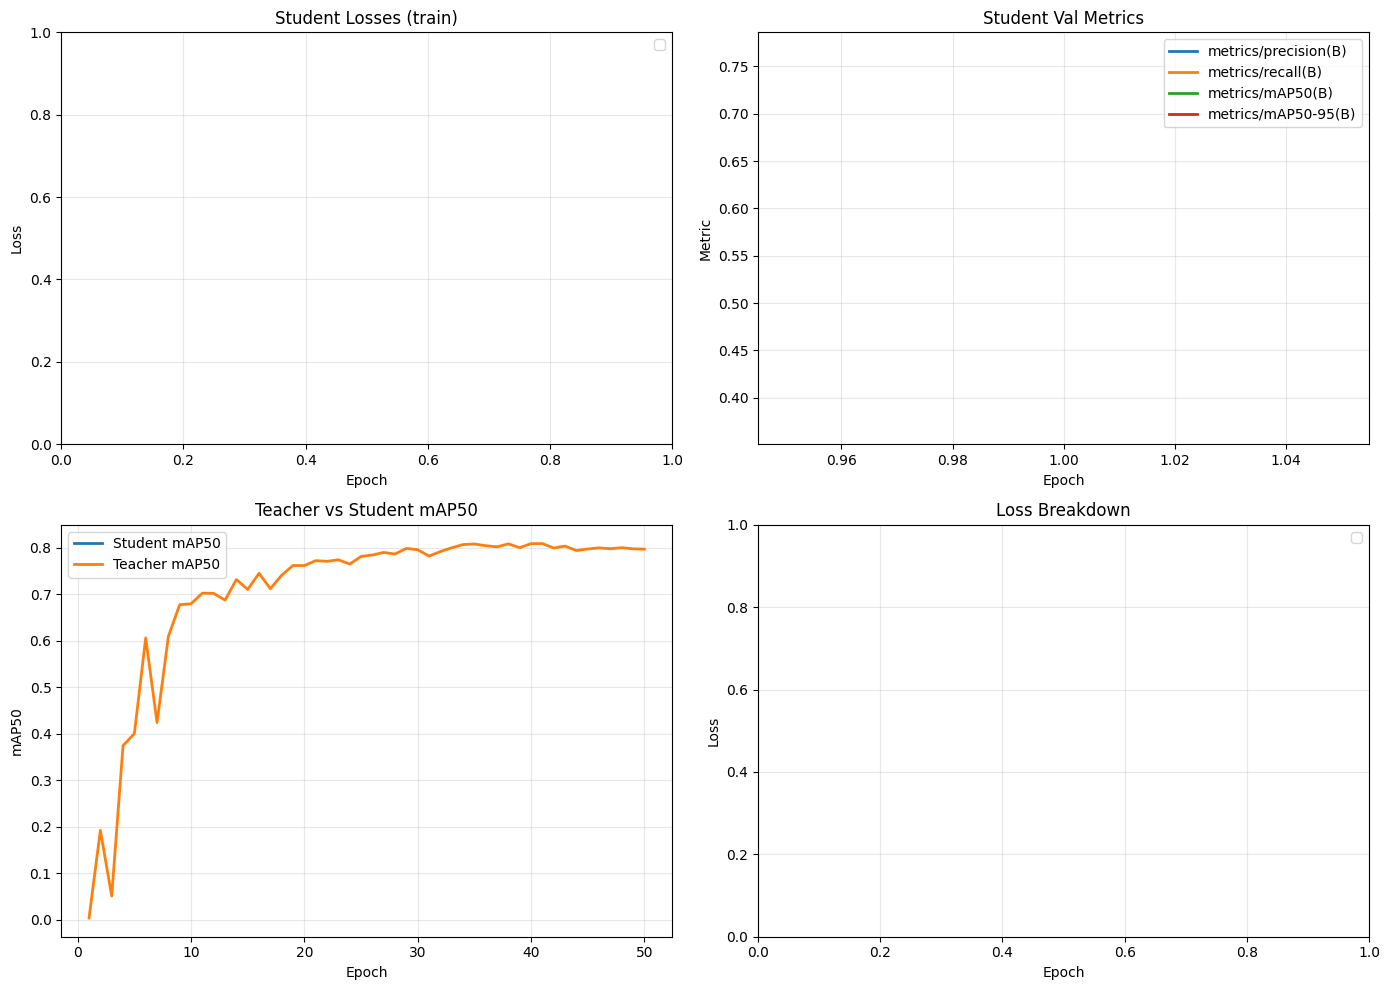

In [4]:
# =========================
# YOLO11 KD Görselleştirme
# =========================
# Gereklilikler: matplotlib, pandas, numpy, opencv-python, scipy, ultralytics (zaten ortamda var)
import os, json, glob, math
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# -----------------------
# PATH AYARLARI (gerekirse değiştir)
# -----------------------
STUDENT_DIR = Path("/content/yolo11_kd_allinone/student/train_featureKD_nopickle")
STUDENT_RESULTS_CSV = STUDENT_DIR / "results.csv"

# Eğer teacher’ı ayrı bir çalıştırmada koşturduysan burayı ona göre ver:
TEACHER_DIR = Path("/content/yolo11_kd_allinone/teacher/train")   # örnek: değiştir/boş bırak
TEACHER_RESULTS_CSV = TEACHER_DIR / "results.csv"

# Valid set (görsel karolar için)
VAL_IMG_DIR = Path("/content/merged-cracks-2/valid/images")
VAL_LABEL_DIR = Path("/content/merged-cracks-2/valid/labels")  # zorunlu değil, varsa GT karşılaştırması çıkar

# (Opsiyonel) Pseudo-label’lar: teacher’ın ürettiği .txt’ler (YOLO format)
# Unlabeled görüntüler için teacher sonuçlarını predict edip kaydettiğin klasör:
PSEUDO_IMG_DIR = Path("/content/unlabeled/images")      # yoksa bırak
PSEUDO_TEACHER_TXT_DIR = Path("/content/pseudo_labels/labels")  # yoksa bırak
PSEUDO_STUDENT_TXT_DIR = Path("/content/pseudo_student/labels") # öğrenci de üretmişse karşılaştırır

SAVE_DIR = STUDENT_DIR / "_viz"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------
# Yardımcılar
# -----------------------
def safe_read_csv(p):
    if p.exists():
        try:
            return pd.read_csv(p)
        except Exception as e:
            print(f"[WARN] CSV okunamadı: {p} -> {e}")
    return None

def plot_series(ax, df, cols, title, xlabel="Epoch", ylabel="Value", legend=True):
    for c in cols:
        if c in df.columns:
            ax.plot(df.index+1, df[c], label=c, linewidth=2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if legend: ax.legend()
    ax.grid(True, alpha=0.3)

def iou_xyxy(a, b):
    # a: [N,4], b: [M,4], format [x1,y1,x2,y2]
    if a.size == 0 or b.size == 0:
        return np.zeros((a.shape[0], b.shape[0]), dtype=np.float32)
    tl = np.maximum(a[:, None, :2], b[None, :, :2])
    br = np.minimum(a[:, None, 2:], b[None, :, 2:])
    wh = np.clip(br - tl, 0, None)
    inter = wh[..., 0]*wh[..., 1]
    area_a = (a[:, 2]-a[:, 0])*(a[:, 3]-a[:, 1])
    area_b = (b[:, 2]-b[:, 0])*(b[:, 3]-b[:, 1])
    iou = inter / (area_a[:, None] + area_b[None, :] - inter + 1e-9)
    return iou

def yolo_txt_to_xyxy(txt_path, img_w, img_h, conf_ok=True):
    # YOLO: class cx cy w h [conf]
    # dönen: (xyxy [N,4], conf [N], cls [N])
    if not txt_path.exists():
        return np.zeros((0,4), float), np.zeros((0,), float), np.zeros((0,), int)
    data = []
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(float(parts[0]))
            cx, cy, w, h = map(float, parts[1:5])
            conf = float(parts[5]) if len(parts) >= 6 else (1.0 if conf_ok else 0.0)
            x1 = (cx - w/2) * img_w
            y1 = (cy - h/2) * img_h
            x2 = (cx + w/2) * img_w
            y2 = (cy + h/2) * img_h
            data.append((x1,y1,x2,y2,conf,cls))
    if not data:
        return np.zeros((0,4), float), np.zeros((0,), float), np.zeros((0,), int)
    arr = np.array(data, float)
    return arr[:, :4], arr[:, 4], arr[:, 5].astype(int)

def draw_boxes(img, boxes, confs=None, color=(0,255,0), label=""):
    out = img.copy()
    for i, b in enumerate(boxes.astype(int)):
        x1,y1,x2,y2 = b
        cv2.rectangle(out, (x1,y1), (x2,y2), color, 2)
        if confs is not None and len(confs)>i:
            t = f"{label}{confs[i]:.2f}" if label else f"{confs[i]:.2f}"
        else:
            t = label
        if t:
            cv2.putText(out, t, (x1, max(10,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)
    return out

def mosaic(images, cols=2, pad=8, bg=255):
    if len(images)==0:
        return None
    h = max(im.shape[0] for im in images)
    w = max(im.shape[1] for im in images)
    rows = math.ceil(len(images)/cols)
    canvas = np.full((rows*h + (rows+1)*pad, cols*w + (cols+1)*pad, 3), bg, dtype=np.uint8)
    idx=0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(images): break
            im = images[idx]
            ih, iw = im.shape[:2]
            y = pad + r*(h+pad)
            x = pad + c*(w+pad)
            canvas[y:y+ih, x:x+iw] = im
            idx += 1
    return canvas

# -----------------------
# 1) Eğitim eğrileri: student (+ teacher varsa)
# -----------------------
stu = safe_read_csv(STUDENT_RESULTS_CSV)
tea = safe_read_csv(TEACHER_RESULTS_CSV)

if stu is None:
    raise SystemExit(f"Student results.csv bulunamadı: {STUDENT_RESULTS_CSV}")

plt.figure(figsize=(14,10))
ax1 = plt.subplot(2,2,1)
plot_series(ax1, stu, ["box_loss","cls_loss","dfl_loss"], "Student Losses (train)", ylabel="Loss")

ax2 = plt.subplot(2,2,2)
plot_series(ax2, stu, ["metrics/precision(B)","metrics/recall(B)","metrics/mAP50(B)","metrics/mAP50-95(B)"],
            "Student Val Metrics", ylabel="Metric")

ax3 = plt.subplot(2,2,3)
if tea is not None:
    # Ortak mAP50 grafiği
    cols = []
    if "metrics/mAP50(B)" in stu.columns: cols.append(("Student mAP50", stu["metrics/mAP50(B)"].values))
    if "metrics/mAP50(B)" in tea.columns: cols.append(("Teacher mAP50", tea["metrics/mAP50(B)"].values))
    for name, arr in cols:
        plt.plot(np.arange(1,len(arr)+1), arr, label=name, linewidth=2)
    plt.title("Teacher vs Student mAP50")
    plt.xlabel("Epoch"); plt.ylabel("mAP50"); plt.grid(True, alpha=0.3); plt.legend()
else:
    plot_series(ax3, stu, ["lr/pg0","lr/pg1","lr/pg2"], "Learning Rate Groups", ylabel="LR")

ax4 = plt.subplot(2,2,4)
# Class loss / box loss ayrıştırması (teacher de varsa üzerine çizer)
plot_series(ax4, stu, ["cls_loss","box_loss","dfl_loss"], "Loss Breakdown", ylabel="Loss")

plt.tight_layout()
plt.savefig(SAVE_DIR/"training_curves.png", dpi=160)
print(f"[OK] Eğitim eğrileri kaydedildi: {SAVE_DIR/'training_curves.png'}")

# -----------------------
# 2) Valid görüntülerinden QUALITATIVE mozaik: Student tahminleri
# -----------------------
# Ultralytics, val tahminlerini otomatik kaydetmez. İstersek hızlı bir predict alalım:
try:
    from ultralytics import YOLO
    model = YOLO(str(STUDENT_DIR.parent / "weights" / "last.pt")) if (STUDENT_DIR.parent/"weights/last.pt").exists() else YOLO("yolo11n.pt")
    pred_dir = SAVE_DIR/"student_val_preds"
    pred_dir.mkdir(exist_ok=True, parents=True)
    # Hızlı bir alt-küme (örn. 16 görsel)
    val_imgs = sorted(glob.glob(str(VAL_IMG_DIR/"*.jpg")) + glob.glob(str(VAL_IMG_DIR/"*.png")) + glob.glob(str(VAL_IMG_DIR/"*.jpeg")))
    sample_imgs = val_imgs[:16] if len(val_imgs)>16 else val_imgs
    if sample_imgs:
        _ = model.predict(source=sample_imgs, save_txt=True, save_conf=True, project=str(pred_dir), name="run", verbose=False, imgsz=640, conf=0.25, iou=0.7)
        pred_txt_base = pred_dir/"run"/"labels"
        tiles = []
        for p in sample_imgs:
            img = cv2.imread(p)
            h,w = img.shape[:2]
            txt = pred_txt_base/(Path(p).stem + ".txt")
            boxes, confs, _ = yolo_txt_to_xyxy(txt, w, h)
            vis = draw_boxes(img, boxes, confs, color=(0,255,0), label="")
            tiles.append(vis)
        grid = mosaic(tiles, cols=4)
        if grid is not None:
            cv2.imwrite(str(SAVE_DIR/"student_val_mosaic.jpg"), grid)
            print(f"[OK] Student val mozaik: {SAVE_DIR/'student_val_mosaic.jpg'}")
except Exception as e:
    print(f"[WARN] Val mozaik üretilemedi: {e}")

# -----------------------
# 3) Teacher vs Student: Aynı karede iki model
# -----------------------
try:
    tea_model = None
    if (TEACHER_DIR.parent/"weights/last.pt").exists():
        tea_model = YOLO(str(TEACHER_DIR.parent/"weights/last.pt"))
    elif TEACHER_DIR.exists():
        # varsa doğrudan teacher ağı (ör. yolo11l.pt gibi)
        pass

    if 'sample_imgs' in locals() and sample_imgs and tea_model is not None:
        tea_pred_dir = SAVE_DIR/"teacher_val_preds"
        tea_pred_dir.mkdir(exist_ok=True, parents=True)
        _ = tea_model.predict(source=sample_imgs, save_txt=True, save_conf=True, project=str(tea_pred_dir), name="run", verbose=False, imgsz=640, conf=0.25, iou=0.7)
        ttxt = tea_pred_dir/"run"/"labels"
        stxt = pred_dir/"run"/"labels"

        tiles = []
        for p in sample_imgs:
            img = cv2.imread(p)
            h,w = img.shape[:2]
            tb, tc, _ = yolo_txt_to_xyxy(ttxt/(Path(p).stem+".txt"), w, h)
            sb, sc, _ = yolo_txt_to_xyxy(stxt/(Path(p).stem+".txt"), w, h)
            out = draw_boxes(img, tb, tc, (255,0,0), "T:")
            out = draw_boxes(out, sb, sc, (0,255,0), "S:")
            tiles.append(out)
        grid = mosaic(tiles, cols=4)
        if grid is not None:
            cv2.imwrite(str(SAVE_DIR/"teacher_student_val_mosaic.jpg"), grid)
            print(f"[OK] Teacher-Student val mozaik: {SAVE_DIR/'teacher_student_val_mosaic.jpg'}")
except Exception as e:
    print(f"[WARN] Teacher-Student mozaik üretilemedi: {e}")

# -----------------------
# 4) Pseudo-label kalite analizi (IoU eşleşme + güven puanı histogramı)
# -----------------------
def pair_quality(img_path, tdir, sdir):
    img = cv2.imread(img_path)
    if img is None:
        return None
    h,w = img.shape[:2]
    stem = Path(img_path).stem
    tb, tc, _ = yolo_txt_to_xyxy((tdir/(stem+".txt")), w, h)
    sb, sc, _ = yolo_txt_to_xyxy((sdir/(stem+".txt")), w, h)
    iou_mat = iou_xyxy(tb, sb)
    if iou_mat.size == 0:
        return [], [], [], []
    # Hungarian: max IoU için cost = 1 - IoU
    cost = 1.0 - iou_mat
    r, c = linear_sum_assignment(cost)
    ious = []
    tconf = []
    sconf = []
    for ri, ci in zip(r, c):
        ious.append(iou_mat[ri, ci])
        tconf.append(tc[ri] if ri < len(tc) else 0.0)
        sconf.append(sc[ci] if ci < len(sc) else 0.0)
    return ious, tconf, sconf, (tb, sb, tc, sc)

if PSEUDO_IMG_DIR.exists() and PSEUDO_TEACHER_TXT_DIR.exists():
    pseudo_imgs = sorted(glob.glob(str(PSEUDO_IMG_DIR/"*.jpg")) + glob.glob(str(PSEUDO_IMG_DIR/"*.png")) + glob.glob(str(PSEUDO_IMG_DIR/"*.jpeg")))
    pseudo_imgs = pseudo_imgs[:100]  # hız için örnek alt-küme
    all_iou, all_tc, all_sc = [], [], []
    samp_vis = []

    for p in pseudo_imgs:
        res = pair_quality(p, PSEUDO_TEACHER_TXT_DIR, PSEUDO_STUDENT_TXT_DIR if PSEUDO_STUDENT_TXT_DIR.exists() else PSEUDO_TEACHER_TXT_DIR)
        if res is None:
            continue
        ious, tconf, sconf, pack = res
        all_iou += ious
        all_tc  += tconf
        all_sc  += sconf
        # Görsel örneklerden 8 adet
        if len(samp_vis) < 8 and pack:
            img = cv2.imread(p)
            tb, sb, tc, sc = pack
            vis = draw_boxes(img, tb, tc, (255,0,0), "T:")
            vis = draw_boxes(vis, sb, sc, (0,255,0), "S:")
            samp_vis.append(vis)

    if all_iou:
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.hist(all_iou, bins=20)
        plt.title("Teacher-Student IoU Dağılımı"); plt.xlabel("IoU"); plt.ylabel("Adet")

        plt.subplot(1,3,2)
        plt.hist(all_tc, bins=20)
        plt.title("Teacher Conf Dağılımı"); plt.xlabel("conf"); plt.ylabel("Adet")

        plt.subplot(1,3,3)
        plt.hist(all_sc, bins=20)
        plt.title("Student/Pseudo Conf Dağılımı"); plt.xlabel("conf"); plt.ylabel("Adet")

        plt.tight_layout()
        plt.savefig(SAVE_DIR/"pseudo_quality_hist.png", dpi=160)
        print(f"[OK] Pseudo-label histogramları: {SAVE_DIR/'pseudo_quality_hist.png'}")

        grid = mosaic(samp_vis, cols=4)
        if grid is not None:
            cv2.imwrite(str(SAVE_DIR/"pseudo_samples.jpg"), grid)
            print(f"[OK] Pseudo örnek mozaik: {SAVE_DIR/'pseudo_samples.jpg'}")
    else:
        print("[INFO] Pseudo eşleşme bulunamadı (IoU listesi boş).")

else:
    print("[INFO] Pseudo-label klasörleri tanımlı değil; bu bölüm atlandı.")

# -----------------------
# 5) Özlü rapor (txt)
# -----------------------
report_lines = []
report_lines.append("== KD / Training Quick Report ==")
if "metrics/mAP50(B)" in stu.columns:
    best_ep = int(np.argmax(stu["metrics/mAP50(B)"].values) + 1)
    report_lines.append(f"Student best mAP50 epoch: {best_ep}, value: {stu['metrics/mAP50(B)'].iloc[best_ep-1]:.3f}")
if tea is not None and "metrics/mAP50(B)" in tea.columns:
    tbest_ep = int(np.argmax(tea["metrics/mAP50(B)"].values) + 1)
    report_lines.append(f"Teacher best mAP50 epoch: {tbest_ep}, value: {tea['metrics/mAP50(B)'].iloc[tbest_ep-1]:.3f}")
open(SAVE_DIR/"quick_report.txt","w").write("\n".join(report_lines))
print(f"[OK] quick_report: {SAVE_DIR/'quick_report.txt'}")
